In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fast')

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

In [37]:
import os, sys
# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

from utils.config_reader import config_reader
# Import parameters
config = config_reader('../config/config.json')
random_seed = config.random_seed
path_figures = config.path_figures

df = pd.read_csv(config.data_path + 'segmentation.zip')


In [38]:
data = df.copy()
data.sample(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2812,C12894,1485.081634,1.000000,48.22,...,338.531014,542.822761,0.000000,12
3020,C13109,1492.035204,1.000000,2429.23,...,4373.664316,373.988419,0.000000,12
7329,C17527,734.729977,0.727273,0.00,...,1596.300157,179.245282,0.181818,12
3135,C13225,7387.803893,1.000000,208.00,...,1613.637071,1686.828820,0.000000,12
6095,C16266,16.167257,1.000000,171.90,...,145.002943,147.054838,0.875000,10


**Feature description**
* CUST_ID: Credit card holder ID
* BALANCE: Monthly average balance (based on daily balance averages)
* BALANCE_FREQUENCY: Ratio of the last 12 months with balance
* PURCHASES: Total purchase amount spent during last 12 months
* ONEOFF_PURCHASES: Total amount of one-off purchases
* INSTALLMENTS_PURCHASES: Total amount of installment purchases
* CASH_ADVANCE: Total cash-advance amount
* PURCHASES_ FREQUENCY: Frequency of purchases (Percent of months with at least one purchase)
* ONEOFF_PURCHASES_FREQUENCY: Frequency of one-off-purchases PURCHASES_INSTALLMENTS_FREQUENCY: Frequency of installment purchases
* CASH_ADVANCE_ FREQUENCY: Cash-Advance frequency
* AVERAGE_PURCHASE_TRX: Average amount per purchase transaction
* CASH_ADVANCE_TRX: Average amount per cash-advance transaction
* PURCHASES_TRX: Average amount per purchase transaction
* CREDIT_LIMIT: Credit limit
* PAYMENTS: Total payments (due amount paid by the customer to decrease their statement balance) in the period
* MINIMUM_PAYMENTS: Total minimum payments due in the period.
* PRC_FULL_PAYMEN: Percentage of months with full payment of the due statement balance
* TENURE: Number of months as a customer

In [17]:
print(data.shape)
data.info()

(8950, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  


In [46]:
display(data['CUST_ID'].duplicated().value_counts())

data.drop(['CUST_ID'], axis=1, inplace=True)

1. Missed values

In [39]:
cols_null_val = data.isnull().sum()
cols_with_null = cols_null_val[cols_null_val > 0].sort_values(ascending=False)
display(cols_with_null)


MINIMUM_PAYMENTS    313
CREDIT_LIMIT          1
dtype: int64

In [31]:
print('Total missed entries: {}'.format(data.isna().sum().sum()))

Total missed entries: 314


2. Fill missed values with means

In [42]:
missed_cols = list(cols_with_null.index)
for col in missed_cols:
    median = data[col].mean()               
    data[col].fillna(median, inplace=True)
print("Mean value for the 'MINIMUM_PAYMENTS' feature: {:.2f}".format(data['MINIMUM_PAYMENTS'].mean()))

Mean value for the 'MINIMUM_PAYMENTS' feature: 864.21


3. Normalization

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)
X_scaled = pd.DataFrame(X_scaled, columns=data.columns)
X_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,...,-0.528979,-3.109675e-01,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,...,0.818642,8.931021e-02,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,...,-0.383805,-1.016632e-01,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,...,-0.598688,4.878305e-17,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,...,-0.364368,-2.657913e-01,-0.525551,0.36068


In [55]:
X_scaled.iloc[0][0].round(2)

-0.73

4. clusterization with K-means

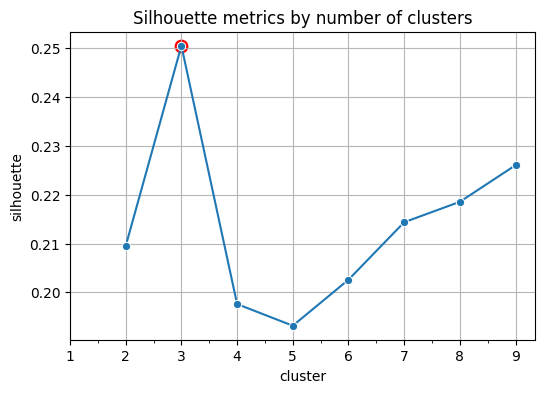

In [60]:
def get_silhouette(cluster_num:int, data:pd.DataFrame)->float:
    """Get silhouette metrics with k-means algorythm 

    Args:
        cluster_num (int): given number of clusters
        X (pd.DataFrame): features

    Returns:
        float: silhouette metrics
    """    
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=random_seed).fit(data)

    return silhouette_score(data, k_means.predict(data))


silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X_scaled))
    silhouette_res["cluster"].append(cluster_num)
    
silhouette_df = pd.DataFrame(silhouette_res)

fig, ax = plt.subplots(figsize = (6, 4))
fig = sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o",ax=ax)
fig.set_title('Silhouette metrics by number of clusters', y=-0.25)

# highlight the optimum value
xx,yy =  np.argmax(silhouette_df['silhouette'].values), np.max(silhouette_df['silhouette'].values)
plt.scatter(x=xx+2, y=yy, marker= "o", c='r',s=80)
plt.annotate(f'optimal num_clusters = {xx+2}', xy=(xx+2+0.5, yy))
minor_ticks = np.arange(1, 9, 0.5)
major_ticks = np.arange(2, 10, 1)
ax.set_xticks(minor_ticks, minor=True);
#ax.grid(which='major', alpha=0.9);

In [100]:
#X_scaled.drop(['Clusters_kmeans'], axis=1, inplace=True)

In [94]:
kmeans = KMeans( n_clusters=3, n_init=10, random_state=random_seed) #init='k-means++',  
kmeans.fit(X_scaled)
#predictions = kmeans.labels_

#X_scaled['Clusters_kmeans'] = kmeans.labels_

#X_scaled['Clusters_kmeans'].value_counts()
np.unique(kmeans.labels_, return_counts=True)

0    6118
1    1597
2    1235
Name: Clusters_kmeans, dtype: int64

In [99]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2]), array([6118, 1597, 1235], dtype=int64))

7. DBSCAN

In [115]:
db = DBSCAN().fit(X_scaled)

clusters = db.labels_
len(set(clusters)) - (1 if -1 in clusters else 0)

38

In [296]:
def get_silhouette_db(data:pd.DataFrame, eps:float, samples:float)->float:
    """Get silhouette metrics with the DBSCAN algorythm

    Args:
        cluster_num (int): given number of clusters
        X (pd.DataFrame): features

    Returns:
        float: silhouette metrics
    """    
    db = DBSCAN(eps=eps, min_samples=samples).fit(data)
    
    return silhouette_score(data, db.labels_, metric='euclidean')
    
silhouette_res = {"silhouette": [], "eps": [], "min_samples": [] }#'clusters_num':[]

for eps in np.arange(0.1,3,0.2):
    for samples in range(1,20,4):
        silhouette_res["silhouette"].append(get_silhouette_db(X_scaled, eps, samples))
        silhouette_res["eps"].append(eps)
        silhouette_res["min_samples"].append(samples)
        #silhouette_res["clusters_num"].append(np.unique(db.labels_))
    
silhouette_df = pd.DataFrame(silhouette_res)
silhouette_df.sort_values(by='silhouette', ascending=False)

best_params = silhouette_df.sort_values(by='silhouette', ascending=False).values[0][1:]

print('Best parameters are: \n', best_params)

Best parameters are: 
 [2.9 5. ]


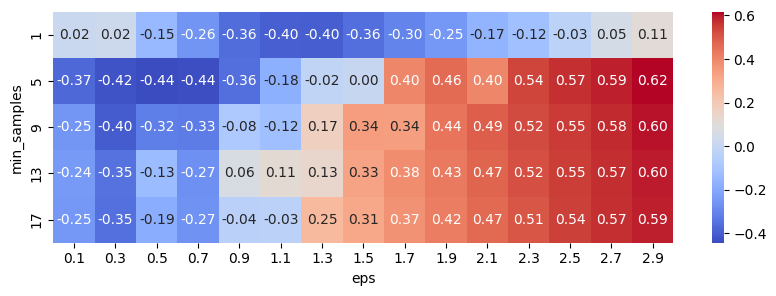

In [165]:
pivot = pd.pivot_table(data=silhouette_df,
                       columns = silhouette_df['eps'].round(1),
                       index='min_samples',
                       values='silhouette')
fig = plt.figure(figsize=(10,3))
sns.heatmap(pivot, annot=True, fmt='.02f', cmap='coolwarm');

In [294]:
db = DBSCAN(eps=2.9, min_samples=5).fit(X_scaled)
np.unique(db.labels_)



array([-1,  0], dtype=int64)

8. agglomerative clustering

In [185]:
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_clustering.fit(X_scaled)

agg_clustering.labels_ [:10]

def get_silhouette_agg(cluster_num:int, data:pd.DataFrame)->float:
    """Get silhouette metrics with Agglomerative_clustering algorythm 

    Args:
        cluster_num (int): given number of clusters
        X (pd.DataFrame): features

    Returns:
        float: silhouette metrics
    """    
    agg_clustering =  AgglomerativeClustering(n_clusters=cluster_num, metric='euclidean').fit(data)

    return silhouette_score(data, agg_clustering.labels_)

silhouette_res = {"silhouette": [], "clusters": []}

for cluster_num in range(3, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg(cluster_num, X_scaled))
    silhouette_res["clusters"].append(cluster_num)
silhouette_res

{'silhouette': [0.1731098007232828,
  0.1547093352037027,
  0.15806867978666445,
  0.17335577924064002,
  0.156415467090623,
  0.15203451293262077,
  0.15371895842035113],
 'clusters': [3, 4, 5, 6, 7, 8, 9]}

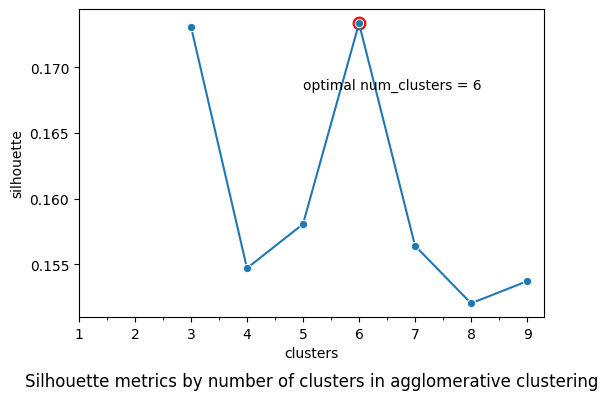

In [194]:
silhouette_df = pd.DataFrame(silhouette_res)

fig, ax = plt.subplots(figsize = (6, 4))
fig = sns.lineplot(data=silhouette_df, x="clusters", y="silhouette", marker= "o", ax=ax)
fig.set_title('Silhouette metrics by number of clusters in agglomerative clustering', y=-0.25)

# highlight the optimum value
xx,yy =  np.argmax(silhouette_df['silhouette'].values), np.max(silhouette_df['silhouette'].values)
plt.scatter(x=xx+3, y=yy, marker= "o", c='r',s=80)
plt.annotate(f'optimal num_clusters = {xx+3}', xy=(xx+2, yy-0.005))
minor_ticks = np.arange(1, 9, 0.5)
major_ticks = np.arange(3, 10, 1)
ax.set_xticks(minor_ticks, minor=True);
#ax.grid(which='major', alpha=0.9);

In [252]:
agg_clustering =  AgglomerativeClustering(n_clusters=6, metric='euclidean').fit(X_scaled)
np.unique(agg_clustering.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([3946, 2931,  864,  464,   23,  722], dtype=int64))

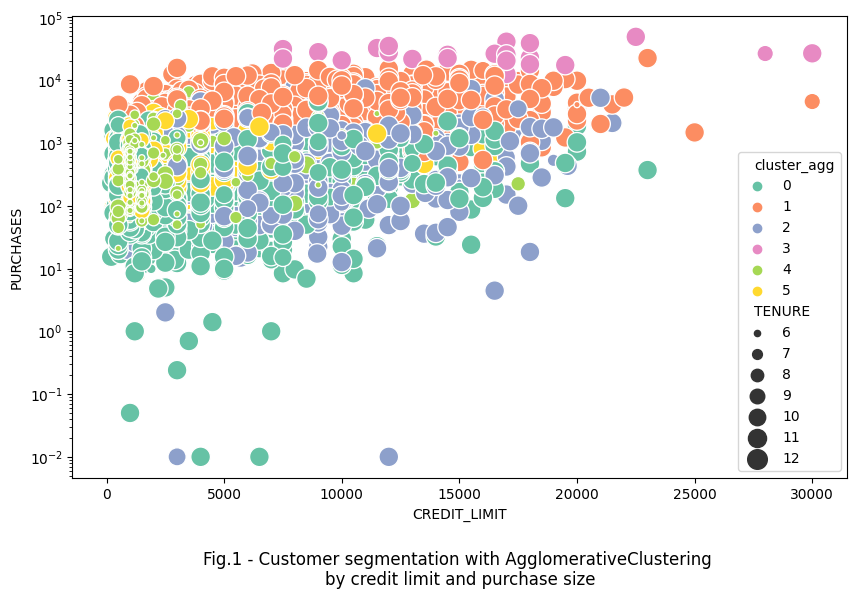

In [292]:
agg_clustering =  AgglomerativeClustering(n_clusters=6, metric='euclidean').fit(X_scaled)
agg_clustering.fit(X_scaled)
data['cluster_agg'] = agg_clustering.labels_

plt.figure(figsize=(10,6))
fig = sns.scatterplot(data=data, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster_agg', size="TENURE", sizes=(20, 200), palette="Set2");
fig.set_yscale('log')
fig.set_title('Fig.1 - Customer segmentation with AgglomerativeClustering \nby credit limit and purchase size', y=-0.25);


10. visualization

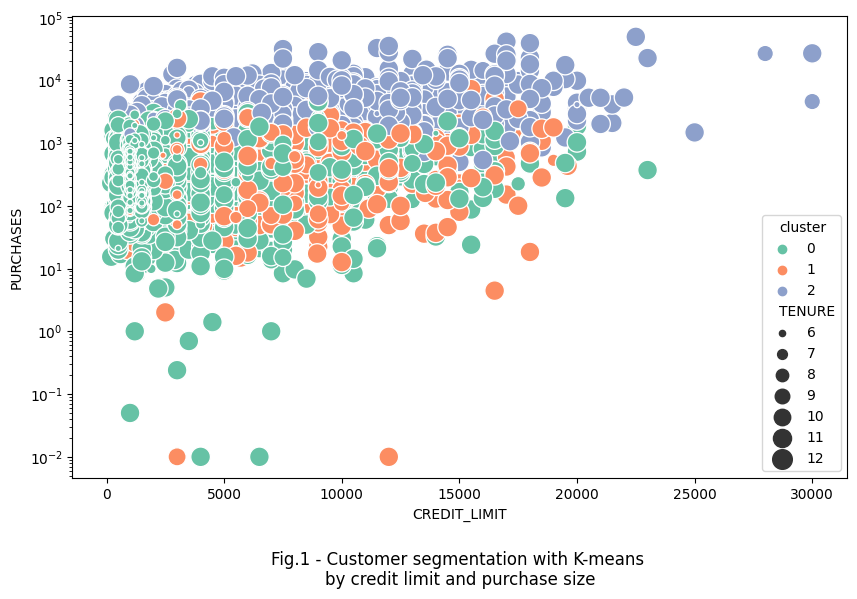

In [293]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans.fit(X_scaled)
data['cluster'] = kmeans.labels_

 
plt.figure(figsize=(10,6))
fig = sns.scatterplot(data=data, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster', size="TENURE", sizes=(20, 200), palette="Set2");
fig.set_yscale('log')
fig.set_title('Fig.1 - Customer segmentation with K-means \nby credit limit and purchase size', y=-0.25);

The Fig.1 represents the customer segmentation using the K-means algorythm. The figure shows following groups:
* cluster 0 contains customers with low credit limit